In [1]:
import torch

x = torch.rand(5, 3)
print(x)

tensor([[3.5719e-01, 9.9952e-01, 4.9652e-01],
        [2.1033e-01, 1.8227e-01, 3.1917e-01],
        [8.2889e-01, 3.7014e-01, 5.3748e-01],
        [1.4768e-01, 1.4662e-01, 3.8330e-01],
        [4.8443e-01, 8.8996e-04, 7.7375e-02]])


In [2]:
import torch
torch.cuda.is_available()

False

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [4]:
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

100.0%
100.0%
100.0%
100.0%


In [5]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f'Shape of X [N, C, H, W]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [6]:
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f'Using {device} device')

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f'loss: {loss:>7f} [{current:>5d} / {size:>5d}]')

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')

In [13]:
epochs = 5
for t in range(epochs):
    print(f'Epoch {t+1}\n----------------------')
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print('Done!')

Epoch 1
----------------------
loss: 2.306917 [   64 / 60000]
loss: 2.290190 [ 6464 / 60000]
loss: 2.274233 [12864 / 60000]
loss: 2.278160 [19264 / 60000]
loss: 2.255375 [25664 / 60000]
loss: 2.225019 [32064 / 60000]
loss: 2.243378 [38464 / 60000]
loss: 2.208156 [44864 / 60000]
loss: 2.208117 [51264 / 60000]
loss: 2.183669 [57664 / 60000]
Test Error: 
 Accuracy: 39.1%, Avg loss: 2.172690 

Epoch 2
----------------------
loss: 2.183723 [   64 / 60000]
loss: 2.168788 [ 6464 / 60000]
loss: 2.120687 [12864 / 60000]
loss: 2.141765 [19264 / 60000]
loss: 2.090572 [25664 / 60000]
loss: 2.029862 [32064 / 60000]
loss: 2.069707 [38464 / 60000]
loss: 1.996597 [44864 / 60000]
loss: 1.999782 [51264 / 60000]
loss: 1.936716 [57664 / 60000]
Test Error: 
 Accuracy: 52.9%, Avg loss: 1.931118 

Epoch 3
----------------------
loss: 1.962277 [   64 / 60000]
loss: 1.926496 [ 6464 / 60000]
loss: 1.827893 [12864 / 60000]
loss: 1.869468 [19264 / 60000]
loss: 1.752215 [25664 / 60000]
loss: 1.700683 [32064 / 6000

In [14]:
torch.save(model.state_dict(), 'model.pth')
print('Saved PyTorch Model State to model.pth')

Saved PyTorch Model State to model.pth


In [15]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [17]:
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [1]:
import torch
import numpy as np

In [2]:
data = [[1, 2], [3, 4]]
x_data = torch.tensor(data)

In [3]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [4]:
x_ones = torch.ones_like(x_data)
print(f'Ones Tensor: \n {x_ones} \n')

x_rand = torch.rand_like(x_data, dtype=torch.float)
print(f'Random Tensor: \n {x_rand} \n')

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.4066, 0.9483],
        [0.2800, 0.9009]]) 



In [5]:
shape = (2, 3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f'Random Tensor: \n {rand_tensor} \n')
print(f'Ones Tensor: \n {ones_tensor} \n')
print(f'Zeros Tensor: \n {zeros_tensor}')

Random Tensor: 
 tensor([[0.8325, 0.8827, 0.0815],
        [0.2873, 0.0144, 0.1485]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [6]:
tensor = torch.rand(3, 4)

print(f'Shape of tensor: {tensor.shape}')
print(f'Datatype of tensor: {tensor.dtype}')
print(f'Device tensor is stored on: {tensor.device}')

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


In [7]:
if torch.cuda.is_available():
    tensor = tensor.to('cuda')

In [8]:
tensor = torch.ones(4, 4)
print(f'First row: {tensor[0]}')
print(f'First column: {tensor[:, 0]}')
print(f'Last column: {tensor[..., -1]}')
tensor[:,1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [9]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


In [10]:
x = torch.randn(2, 3)
x

tensor([[ 0.0254, -0.1001, -1.0726],
        [-0.9694,  1.3437, -0.2333]])

In [11]:
torch.stack((x, x))

tensor([[[ 0.0254, -0.1001, -1.0726],
         [-0.9694,  1.3437, -0.2333]],

        [[ 0.0254, -0.1001, -1.0726],
         [-0.9694,  1.3437, -0.2333]]])

In [12]:
torch.stack((x, x)).size()

torch.Size([2, 2, 3])

In [14]:
torch.stack((x, x), dim=1)

tensor([[[ 0.0254, -0.1001, -1.0726],
         [ 0.0254, -0.1001, -1.0726]],

        [[-0.9694,  1.3437, -0.2333],
         [-0.9694,  1.3437, -0.2333]]])

In [15]:
torch.stack((x, x), dim=2)

tensor([[[ 0.0254,  0.0254],
         [-0.1001, -0.1001],
         [-1.0726, -1.0726]],

        [[-0.9694, -0.9694],
         [ 1.3437,  1.3437],
         [-0.2333, -0.2333]]])

In [16]:
torch.stack((x, x), dim=-1)

tensor([[[ 0.0254,  0.0254],
         [-0.1001, -0.1001],
         [-1.0726, -1.0726]],

        [[-0.9694, -0.9694],
         [ 1.3437,  1.3437],
         [-0.2333, -0.2333]]])

In [18]:
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)


tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])

In [19]:

z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [20]:
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


In [22]:
print(f'{tensor} \n')
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


In [23]:
t = torch.ones(5)
print(f't: {t}')
n = t.numpy()
print(f'n: {n}')

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


In [24]:
t.add_(1)
print(f't: {t}')
print(f'n: {n}')

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


In [25]:
n = np.ones(5)
t = torch.from_numpy(n)

In [26]:
np.add(n, 1, out=n)
print(f't: {t}')
print(f'n: {n}')

t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


In [28]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

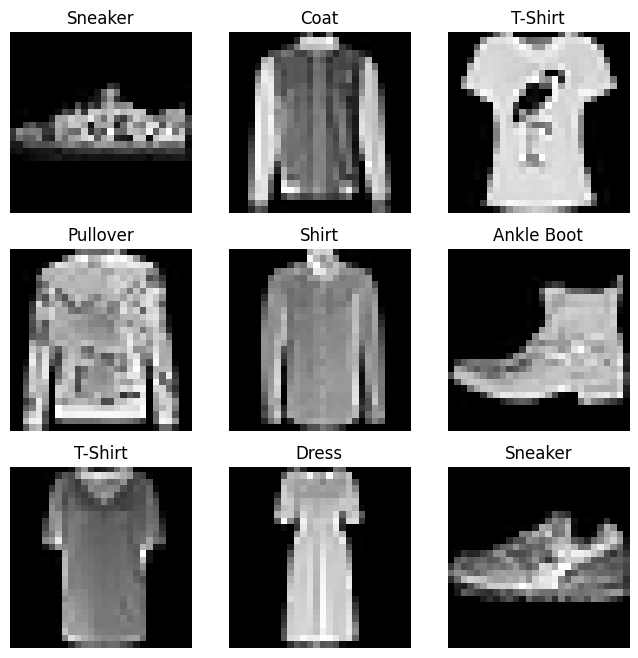

In [30]:
labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [31]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [32]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


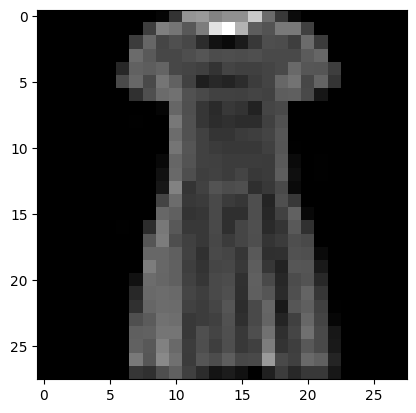

Label: 3


In [33]:
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f'Label: {label}')

In [34]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

In [35]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1
))

In [36]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [37]:
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f'Using {device} device')

Using cpu device


In [44]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [45]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [46]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f'Predicted class: {y_pred}')

Predicted class: tensor([6])


In [47]:
input_image = torch.rand(3, 28, 28)
print(input_image.size())

torch.Size([3, 28, 28])


In [48]:
input_image

tensor([[[0.6794, 0.8441, 0.0075,  ..., 0.5232, 0.8255, 0.7959],
         [0.7919, 0.7828, 0.1640,  ..., 0.9152, 0.4144, 0.5432],
         [0.1538, 0.2456, 0.2554,  ..., 0.1228, 0.2811, 0.7455],
         ...,
         [0.6025, 0.9720, 0.7405,  ..., 0.9364, 0.9250, 0.0995],
         [0.0686, 0.3479, 0.2514,  ..., 0.7381, 0.3911, 0.0276],
         [0.1027, 0.3239, 0.6507,  ..., 0.0328, 0.2709, 0.1872]],

        [[0.8137, 0.1490, 0.0836,  ..., 0.2269, 0.7018, 0.4599],
         [0.8070, 0.6236, 0.9698,  ..., 0.2444, 0.9430, 0.9242],
         [0.8980, 0.7525, 0.8550,  ..., 0.9080, 0.2354, 0.6651],
         ...,
         [0.5644, 0.5804, 0.6816,  ..., 0.7449, 0.7483, 0.2274],
         [0.7993, 0.6313, 0.3557,  ..., 0.4628, 0.8132, 0.0683],
         [0.6833, 0.2635, 0.6428,  ..., 0.1161, 0.1707, 0.1622]],

        [[0.8400, 0.0576, 0.4518,  ..., 0.0919, 0.6321, 0.5423],
         [0.9546, 0.9379, 0.4091,  ..., 0.4358, 0.6755, 0.0749],
         [0.9238, 0.0575, 0.0267,  ..., 0.8714, 0.9979, 0.

In [49]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


In [50]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


In [51]:
print(f'Before ReLU: {hidden1}\n\n')
hidden1 = nn.ReLU()(hidden1)
print(f'After ReLU: {hidden1}')

Before ReLU: tensor([[ 0.3268, -0.3698, -0.4107,  0.0269,  0.4215,  0.5125,  0.5575, -0.3589,
          0.0182,  0.1299, -0.0595, -0.3058,  0.1040,  0.3630,  0.0886,  0.0692,
         -0.0902,  0.1801, -0.5148, -0.6662],
        [ 0.2272, -0.2121, -0.3122, -0.0716,  0.1562,  0.1972,  0.4300, -0.2303,
          0.0650,  0.2452,  0.0263, -0.7712,  0.1603, -0.0386, -0.1155,  0.2054,
         -0.0185, -0.0329, -0.0710, -0.5515],
        [-0.0475, -0.2526, -0.3291,  0.0806,  0.5715,  0.3493, -0.0414, -0.3956,
          0.1799,  0.0333, -0.3797, -0.5662, -0.0894,  0.0718, -0.1107, -0.0082,
         -0.0889, -0.0232, -0.3431, -0.3647]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.3268, 0.0000, 0.0000, 0.0269, 0.4215, 0.5125, 0.5575, 0.0000, 0.0182,
         0.1299, 0.0000, 0.0000, 0.1040, 0.3630, 0.0886, 0.0692, 0.0000, 0.1801,
         0.0000, 0.0000],
        [0.2272, 0.0000, 0.0000, 0.0000, 0.1562, 0.1972, 0.4300, 0.0000, 0.0650,
         0.2452, 0.0263, 0.0000, 0.1603, 0.0000, 0.00

In [52]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3, 28, 28)
logits = seq_modules(input_image)

In [55]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

In [56]:
print(f'Model structure: {model}\n\n')

for name, param in model.named_parameters():
    print(f'Layer: {name} | Size: {param.size()} | Values : {param[:2]}\n')

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0150, -0.0037, -0.0182,  ...,  0.0073,  0.0127,  0.0124],
        [-0.0252, -0.0282, -0.0044,  ...,  0.0350,  0.0149,  0.0132]],
       grad_fn=<SliceBackward0>)

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([ 0.0214, -0.0110], grad_fn=<SliceBackward0>)

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0352,  0.0036, -0.0389,  ...,  0.0265,  0.0249,  0.0173],
        [-0.0250,  0.0214,  0.0130,  ...,  0.0255,  0.0024,  0.0039]],
       grad_fn=<SliceBackward0>)

Layer: linear_relu_stack.2.bias | Siz

In [57]:
import torch

x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [58]:
print(f'Gradient function for z = {z.grad_fn}')
print(f'Gradient function for loss = {loss.grad_fn}')

Gradient function for z = <AddBackward0 object at 0x00000196B07E31F0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x00000196B07E2C20>


In [59]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2786, 0.2624, 0.0785],
        [0.2786, 0.2624, 0.0785],
        [0.2786, 0.2624, 0.0785],
        [0.2786, 0.2624, 0.0785],
        [0.2786, 0.2624, 0.0785]])
tensor([0.2786, 0.2624, 0.0785])


In [60]:
z = torch.matmul(x, w) + b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w) + b
print(z.requires_grad)

True
False


In [61]:
z = torch.matmul(x, w) + b
z_det = z.detach()
print(z_det.requires_grad)

False


In [62]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f'First call\n{inp.grad}')
out.backward(torch.ones_like(out), retain_graph=True)
print(f'\nSecond call\n{inp.grad}')
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f'\nCall after zeroing gradients\n{inp.grad}')

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

In [3]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [4]:
loss_fn = nn.CrossEntropyLoss()

In [5]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f'Epoch {t+1}\n----------------------')
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print('Done!')

Epoch 1
----------------------
loss: 2.305356 [   64/60000]
loss: 2.290583 [ 6464/60000]
loss: 2.275525 [12864/60000]
loss: 2.264025 [19264/60000]
loss: 2.258539 [25664/60000]
loss: 2.218447 [32064/60000]
loss: 2.234297 [38464/60000]
loss: 2.191618 [44864/60000]
loss: 2.201457 [51264/60000]
loss: 2.157486 [57664/60000]
Test Error: 
 Accuracy: 28.2%, Avg loss: 2.155404 

Epoch 2
----------------------
loss: 2.172136 [   64/60000]
loss: 2.152765 [ 6464/60000]
loss: 2.103077 [12864/60000]
loss: 2.105648 [19264/60000]
loss: 2.065789 [25664/60000]
loss: 1.999984 [32064/60000]
loss: 2.026722 [38464/60000]
loss: 1.944049 [44864/60000]
loss: 1.960526 [51264/60000]
loss: 1.872820 [57664/60000]
Test Error: 
 Accuracy: 47.9%, Avg loss: 1.875784 

Epoch 3
----------------------
loss: 1.922549 [   64/60000]
loss: 1.873879 [ 6464/60000]
loss: 1.773753 [12864/60000]
loss: 1.794409 [19264/60000]
loss: 1.708139 [25664/60000]
loss: 1.658336 [32064/60000]
loss: 1.673692 [38464/60000]
loss: 1.580241 [4486

In [9]:
import torch
import torchvision.models as models

model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\hs/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 91.1MB/s] 


In [10]:
model = models.vgg16()
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
torch.save(model, 'model.pth')

In [14]:
model = torch.load('model.pth', weights_only=False)

In [15]:
!pip show torchvision

Name: torchvision
Version: 0.22.0
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: C:\Users\hs\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: numpy, pillow, torch
Required-by: 


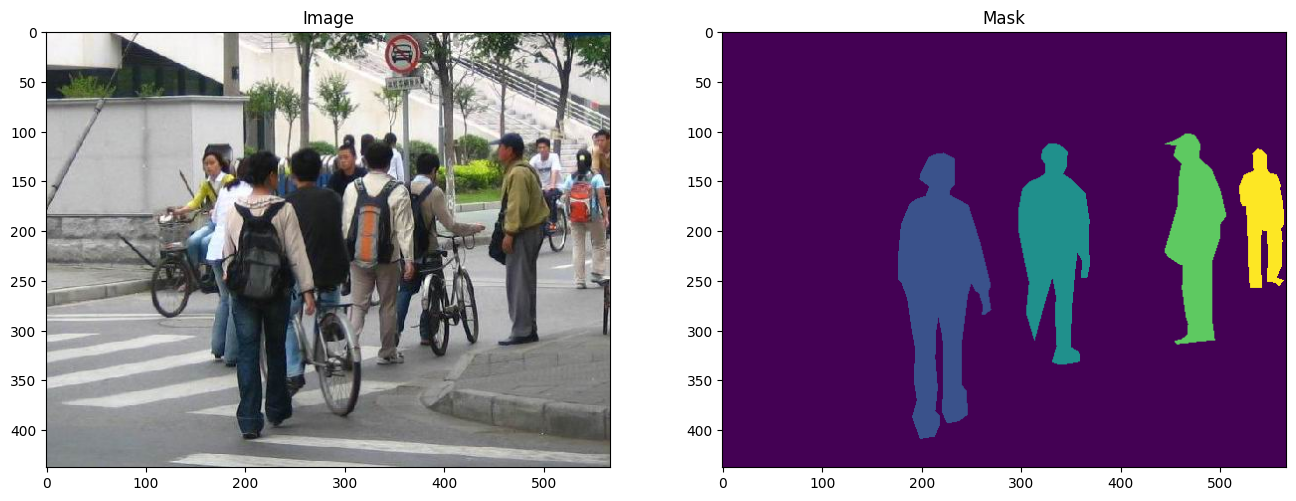

In [2]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image('data/PennFudanPed/PNGImages/FudanPed00046.png')
mask = read_image('data/PennFudanPed/PedMasks/FudanPed00046_mask.png')

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title('Image')
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title('Mask')
plt.imshow(mask.permute(1, 2, 0))

In [2]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, 'PNGImages'))))
        self.masks = list(sorted(os.listdir(os.path.join(root, 'PedMasks'))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'PNGImages', self.imgs[idx])
        mask_path = os.path.join(self.root, 'PedMasks', self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)

        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        boxes = masks_to_boxes(masks)

        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        img = tv_tensors.Image(img)

        target = {}
        target['boxes'] = tv_tensors.BoundingBoxes(boxes, format='XYXY', canvas_size=F.get_size(img))
        target['masks'] = tv_tensors.Mask(masks)
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
    
    def __len__(self):
        return len(self.imgs)

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [4]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

backbone = torchvision.models.mobilenet_v2(weights='DEFAULT').features

backbone.out_channels = 1280

anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [10]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

1

In [11]:
import requests

urls = [
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py"
]

for url in urls:
    filename = url.split("/")[-1]
    print(f"Downloading {filename} ...")
    response = requests.get(url)
    response.raise_for_status()  # 다운로드 실패 시 에러 발생
    with open(filename, "wb") as f:
        f.write(response.content)
    print(f"{filename} saved!")

print("All files downloaded successfully.")


engine.py saved!
utils.py saved!
coco_utils.py saved!
coco_eval.py saved!
transforms.py saved!
All files downloaded successfully.


In [6]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [9]:
from references.detection import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)
print(output)

model.eval()
x = [torch.rand(3,  300, 400), torch.rand(3, 500, 400)]
predictions = model(x)
print(predictions[0])

{'loss_classifier': tensor(0.2190, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1021, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0294, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0097, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [12]:
from engine import train_one_epoch, evaluate

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2

dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

model = get_model_instance_segmentation(num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

num_epochs = 2

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device,epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

print("That's it!")

c:\Users\hs\Desktop\a\program\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:36:43  lr: 0.000090  loss: 3.8189 (3.8189)  loss_classifier: 0.6703 (0.6703)  loss_box_reg: 0.4003 (0.4003)  loss_mask: 2.7264 (2.7264)  loss_objectness: 0.0120 (0.0120)  loss_rpn_box_reg: 0.0100 (0.0100)  time: 36.7231  data: 0.0890
Epoch: [0]  [10/60]  eta: 0:23:30  lr: 0.000936  loss: 1.4241 (1.9846)  loss_classifier: 0.3749 (0.4031)  loss_box_reg: 0.2245 (0.2423)  loss_mask: 0.9376 (1.3171)  loss_objectness: 0.0154 (0.0169)  loss_rpn_box_reg: 0.0053 (0.0053)  time: 28.2139  data: 0.0710
Epoch: [0]  [20/60]  eta: 0:19:36  lr: 0.001783  loss: 0.7373 (1.3912)  loss_classifier: 0.1907 (0.3070)  loss_box_reg: 0.2273 (0.2555)  loss_mask: 0.2940 (0.8056)  loss_objectness: 0.0165 (0.0168)  loss_rpn_box_reg: 0.0054 (0.0062)  time: 29.0599  data: 0.0746
Epoch: [0]  [30/60]  eta: 0:15:23  lr: 0.002629  loss: 0.6078 (1.0985)  loss_classifier: 0.1097 (0.2321)  loss_box_reg: 0.2359 (0.2434)  loss_mask: 0.2051 (0.6027)  loss_objectness: 0.0101 (0.0145)  loss_rpn_box_re

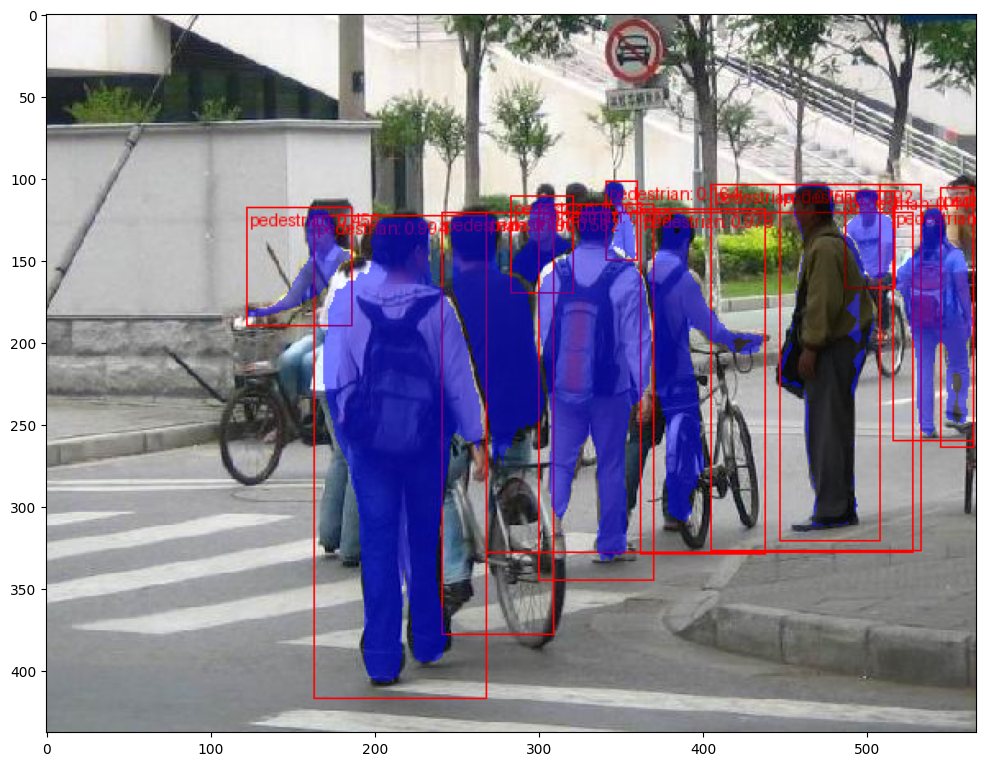

In [15]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image('data/PennFudanPed/PNGImages/FudanPed00046.png')
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)

    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f'pedestrian: {score:.3f}' for label, score in zip(pred['labels'], pred['scores'])]
pred_boxes = pred['boxes'].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors='red')

masks = (pred['masks'] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors='blue')

plt.figure(figsize=(12,12))
plt.imshow(output_image.permute(1, 2, 0))